# Data Preparation - Non-Alcohol Fatty Liver Disease

## A. Introduction

In the exploration of the *NAFLD* dataset, we discovered a few issues, which need to be resolved before the dataset is ready for machine learning. 

- There are missing values in the columns `weight`, `height`, and `bmi`. We can estimate these values depending on the number of missing values and the expected importance of the column.
- We observed that `weight`, `height`, and `bmi` have extreme values at either end. Although they might make intuitive sense, they should be treated appropriately.

## B. Importing Libraries & Dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("Desktop/archive/nafld1.csv")

In [3]:
df.isna().sum()

Unnamed: 0       0
id               0
age              0
male             0
weight        4786
height        3168
bmi           4961
case.id         31
futime           0
status           0
dtype: int64

Before we start transforming the dataset let's make a copy of it.

In [4]:
df_original = df

Columns with ID numbers are unlikely to contain useful information. We decided to drop it.

In [5]:
df.drop('id', axis=1, inplace=True)
df.tail()

,Unnamed: 0,age,male,weight,height,bmi,case.id,futime,status
17544,11130,46,0,53.0,161.0,20.501023,12713.0,1894,0
17545,1099,52,1,111.8,154.0,47.335905,17563.0,3841,0
17546,1522,59,0,57.3,NaN,NaN,16164.0,5081,0
17547,5764,61,0,NaN,NaN,NaN,17276.0,3627,1
17548,6658,69,1,94.1,180.0,29.204650,2017.0,2744,0


In [6]:
df.drop('case.id', axis=1, inplace=True)
df.tail()

,Unnamed: 0,age,male,weight,height,bmi,futime,status
17544,11130,46,0,53.0,161.0,20.501023,1894,0
17545,1099,52,1,111.8,154.0,47.335905,3841,0
17546,1522,59,0,57.3,NaN,NaN,5081,0
17547,5764,61,0,NaN,NaN,NaN,3627,1
17548,6658,69,1,94.1,180.0,29.204650,2744,0


In [7]:
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.tail()

,age,male,weight,height,bmi,futime,status
17544,46,0,53.0,161.0,20.501023,1894,0
17545,52,1,111.8,154.0,47.335905,3841,0
17546,59,0,57.3,NaN,NaN,5081,0
17547,61,0,NaN,NaN,NaN,3627,1
17548,69,1,94.1,180.0,29.204650,2744,0


In [8]:
df.isnull().sum() / len(df) * 100

age        0.000000
male       0.000000
weight    27.272209
height    18.052311
bmi       28.269417
futime     0.000000
status     0.000000
dtype: float64

- Note that height has no more than 25% missing values. Thus, we do not need to consider dropping the column.
- Even though weight and bmi have a little more than 25% missing values, we decised not to drop this column.

## C. Feature Engineering

### Imputation of missing values

It is often useful to impute missing values as many ML algorithms do not work with missing data. Even if they do, imputing these values often helps to build a more accurate predictive model.

There are numerous ways to impute the missing values in a numerical column. The simplest being replacement by mean, which can be done with the following code.

```python
df['weight'].fillna(df['weight'].mean(), inplace=True)
```
Imputing missing values with the mean may introduce bias in the dataset. 

Let's take a simplified approach and fill in the missing values in these columns with the median. Note that the median is likely a better choice than the mean for these columns because the means are not likely to be realistic values.

In [9]:
for col in df.columns:
    if df[col].dtypes != 'object':
        df[col].fillna(df[col].median(),inplace=True)
    else:
        df[col].fillna(df[col].mode()[0],inplace=True)

### Rescaling Featues

Many ML algorithms assume that all numerical features are on the same scale. Two standard techniques in the Python module `scikit-learn` for achieving this are:

* MinMaxScaler - rescales a column to the interval [0,1]
* StandardScaler - rescales a numerical column so that it has mean 0 and standard deviation 1.

Here we use a third technique, called `RobustScaler` to `weight`, `height` and `bmi` which does a better job in the presence of outliers. `RobustScaler` transforms each value in a column by subtracting the median from it and then dividing by the interquartile range.

In [10]:
from sklearn.preprocessing import StandardScaler, RobustScaler

robust_scaler = RobustScaler()
df[['weight',
    'height', 
    'bmi']] = robust_scaler.fit_transform(df[['weight',
                                              'height',
                                              'bmi']])

In [11]:
scaler = StandardScaler()
df[['age',
    'futime']] = scaler.fit_transform(df[['age',
                                              'futime']])

In [12]:
df

,age,male,weight,height,bmi,futime,status
0,0.294820,0,-1.381503,-0.545455,-1.229036,2.447849,0
1,0.974071,0,-0.780347,-0.090909,-0.793238,-1.135811,0
2,0.023119,1,1.265896,1.545455,0.313502,-0.398990,0
3,0.226894,1,1.468208,0.090909,1.779329,0.465615,0
4,1.041996,1,0.000000,0.000000,0.000000,-0.365296,1
...,...,...,...,...,...,...,...
17544,-0.452357,0,-1.786127,-0.727273,-1.664203,-0.328423,0
17545,-0.044806,1,1.612717,-1.363636,3.668267,0.909361,0
17546,0.430670,0,-1.537572,0.000000,0.000000,1.697677,0
17547,0.566520,0,0.000000,0.000000,0.000000,0.773312,1


### Treatment of Outliers

Let's also take a look at their histograms after we have rescaled them.

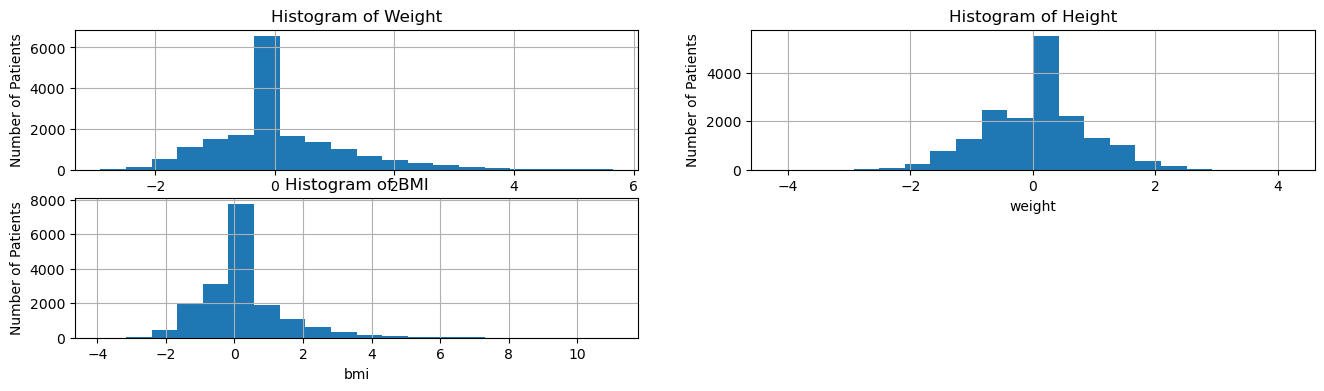

In [13]:
# Create figure with two subplots
fig = plt.figure(figsize=(16,4))

# Plot weight
weight = fig.add_subplot(2,2,1) # top left
weight.set_title("Histogram of Weight")
weight.set_xlabel('weight')
weight.set_ylabel('Number of Patients')
df['weight'].hist(bins=20)

# Plot height
height = fig.add_subplot(2,2,2) # top right
height.set_title("Histogram of Height")
height.set_xlabel('weight')                 
height.set_ylabel('Number of Patients')
df['height'].hist(bins=20)

# Plot bmi
bmi = fig.add_subplot(2,2,3) # bottom left
bmi.set_title("Histogram of BMI")
bmi.set_xlabel('bmi')                 
bmi.set_ylabel('Number of Patients')
df['bmi'].hist(bins=20)

plt.show()

Finally, before treating the outliers, let's find the minimum values in these columns.

In [14]:
df[['weight', 'height','bmi']].min()

weight   -2.919075
height   -4.181818
bmi      -3.908419
dtype: float64

Since the extreme values are practically possible in the three columns instead of ignoring the data rows with extreme values we can transform them to diminish the negative impact of outliers to ML models. A typical way to do this is to apply a log transformation. However, we do have negative values in both columns after rescaling and we need to add a constant to all values in order to shift them to a positive range before applying a log transformation. 

Here we are have chosen to shift the values to the interval $[1, +\infty]$ before applying a log transformation.

In [15]:
# Use a log transformation to decrease the impact of outliers
df['weight'] = np.log(df['weight']+3.92)
df['height'] = np.log(df['height']+5.18)
df['bmi'] = np.log(df['bmi']+4.91)

Let's plot again.

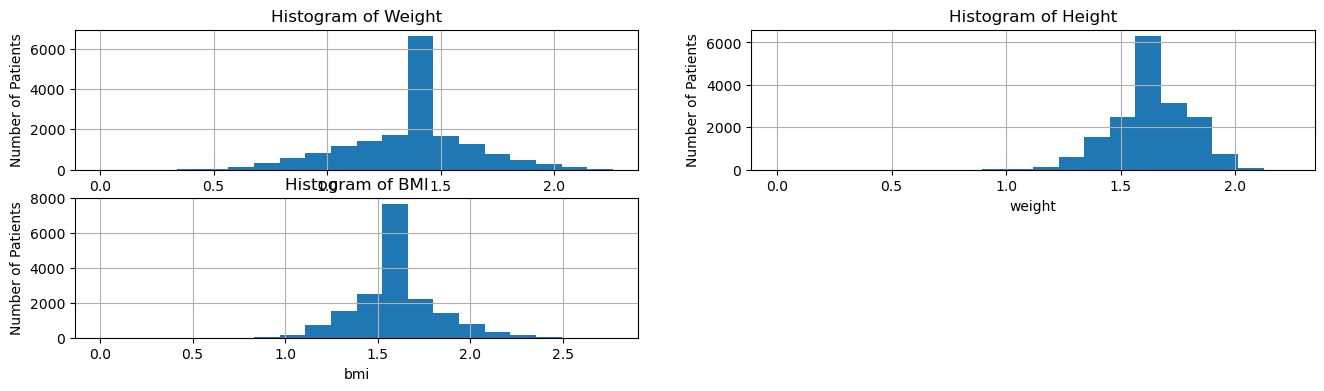

In [16]:
# Create figure with two subplots
fig = plt.figure(figsize=(16,4))

# Plot weight
weight = fig.add_subplot(2,2,1) # top left
weight.set_title("Histogram of Weight")
weight.set_xlabel('weight')
weight.set_ylabel('Number of Patients')
df['weight'].hist(bins=20)

# Plot height
height = fig.add_subplot(2,2,2) # top right
height.set_title("Histogram of Height")
height.set_xlabel('weight')                 
height.set_ylabel('Number of Patients')
df['height'].hist(bins=20)

# Plot bmi
bmi = fig.add_subplot(2,2,3) # bottom left
bmi.set_title("Histogram of BMI")
bmi.set_xlabel('bmi')                 
bmi.set_ylabel('Number of Patients')
df['bmi'].hist(bins=20)

plt.show()

## D. Save the Prepared Dataset

Finally, let's save the prepared dataset as a CSV file.

In [17]:
df.to_csv('nafld_prepared.csv')